In [7]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import timm
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [8]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a transform to convert images to tensor
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()  # Convert image to tensor
])

# Load the datasets with the defined transforms
train_dataset = ImageFolder(root="D:/augmented_images_balance/train", transform=transform)
val_dataset = ImageFolder(root="D:/augmented_images_balance/val", transform=transform)
test_dataset = ImageFolder(root="D:/augmented_images_balance/test", transform=transform)

print(f"training set: {len(train_dataset)}")
print(f"validation set: {len(val_dataset)}")
print(f"test set: {len(test_dataset)}")

training set: 18124
validation set: 1502
test set: 1503


In [9]:
# Create DataLoader for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Initialize the model
model = timm.create_model("swin_tiny_patch4_window7_224", pretrained=True, num_classes=len(train_dataset.classes))
model = model.to(device)

# Loss function and optimizer
class_weights = torch.tensor([0.8030840127614322, 1.3248538011695907], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Learning rate scheduler (Reduce LR if val_loss plateaus)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-6)

# Early stopping parameters
patience = 3  # Number of epochs to wait for improvement
best_val_loss = np.inf
early_stop_counter = 0
num_epochs = 20

# Training loop with Early Stopping
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    
    # Wrap train_loader with tqdm to show progress bar
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", ncols=100):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    avg_train_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation", ncols=100):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

    # Adjust learning rate based on validation loss
    scheduler.step(avg_val_loss)

    # Early Stopping Check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0  # Reset counter
        torch.save(model.state_dict(), "best_model.pth")  # Save the best model
    else:
        early_stop_counter += 1
        print(f"Early stopping counter: {early_stop_counter}/{patience}")

    if early_stop_counter >= patience:
        print("Early stopping triggered. Stopping training.")
        break  # Stop training

print("Training complete. Best model saved as 'best_model.pth'.")

Epoch 1/20: 100%|█████████████████████████████████████████████████| 567/567 [12:14<00:00,  1.30s/it]


Epoch [1/20], Loss: 0.4450, Train Acc: 77.10%


Validation: 100%|███████████████████████████████████████████████████| 47/47 [00:28<00:00,  1.64it/s]


Validation Loss: 0.3782, Validation Accuracy: 79.09%


Epoch 2/20: 100%|█████████████████████████████████████████████████| 567/567 [12:13<00:00,  1.29s/it]


Epoch [2/20], Loss: 0.3421, Train Acc: 83.63%


Validation: 100%|███████████████████████████████████████████████████| 47/47 [00:28<00:00,  1.63it/s]


Validation Loss: 0.3043, Validation Accuracy: 86.68%


Epoch 3/20: 100%|█████████████████████████████████████████████████| 567/567 [12:06<00:00,  1.28s/it]


Epoch [3/20], Loss: 0.2664, Train Acc: 88.18%


Validation: 100%|███████████████████████████████████████████████████| 47/47 [00:28<00:00,  1.67it/s]


Validation Loss: 0.2864, Validation Accuracy: 87.55%


Epoch 4/20: 100%|█████████████████████████████████████████████████| 567/567 [12:09<00:00,  1.29s/it]


Epoch [4/20], Loss: 0.1949, Train Acc: 92.02%


Validation: 100%|███████████████████████████████████████████████████| 47/47 [00:27<00:00,  1.69it/s]


Validation Loss: 0.3283, Validation Accuracy: 87.02%
Early stopping counter: 1/3


Epoch 5/20: 100%|█████████████████████████████████████████████████| 567/567 [12:09<00:00,  1.29s/it]


Epoch [5/20], Loss: 0.1343, Train Acc: 94.61%


Validation: 100%|███████████████████████████████████████████████████| 47/47 [00:28<00:00,  1.68it/s]


Validation Loss: 0.3533, Validation Accuracy: 86.02%
Early stopping counter: 2/3


Epoch 6/20: 100%|█████████████████████████████████████████████████| 567/567 [12:05<00:00,  1.28s/it]


Epoch [6/20], Loss: 0.0993, Train Acc: 96.18%


Validation: 100%|███████████████████████████████████████████████████| 47/47 [00:27<00:00,  1.70it/s]

Validation Loss: 0.4475, Validation Accuracy: 86.75%
Early stopping counter: 3/3
Early stopping triggered. Stopping training.
Training complete. Best model saved as 'best_model.pth'.


In [10]:
test_dataset = ImageFolder(root="D:/augmented_images_balance/test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

correct, total = 0, 0

all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Test Evaluation", ncols=100):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")


Test Evaluation:   0%|                                                       | 0/47 [00:00<?, ?it/s]

Test Evaluation: 100%|██████████████████████████████████████████████| 47/47 [00:28<00:00,  1.68it/s]

Test Accuracy: 86.69%


In [12]:
# Get predictions
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy()) 

# Print classification report
print(classification_report(all_labels, all_preds))


              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1210
           1       0.68      0.60      0.64       293

    accuracy                           0.87      1503
   macro avg       0.79      0.76      0.78      1503
weighted avg       0.86      0.87      0.86      1503



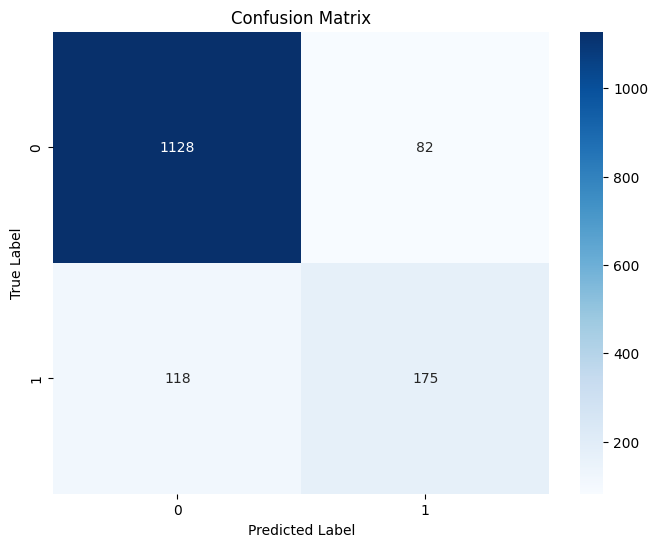

In [13]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

ROC AUC: 0.9065


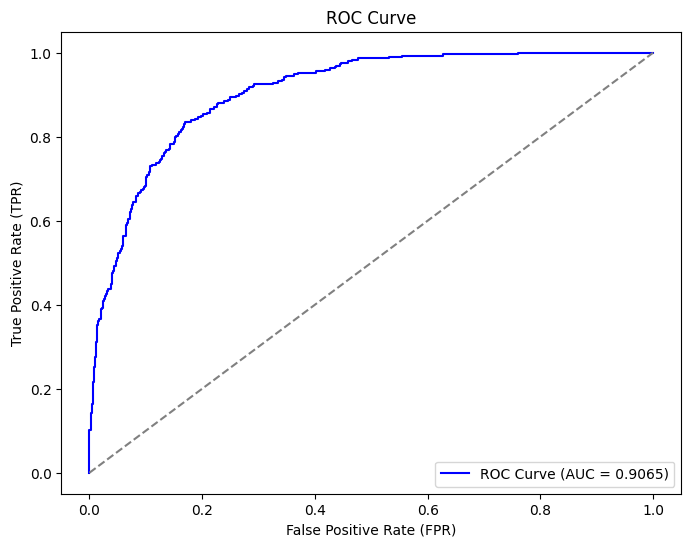

In [14]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device) 
model.eval()

all_preds_prob = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)

        if outputs.shape[1] == 1: 
            probs = torch.sigmoid(outputs).squeeze(1)
        else:
            probs = F.softmax(outputs, dim=1)[:, 1] 

        all_preds_prob.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

roc_auc = roc_auc_score(all_labels, all_preds_prob)
print(f"ROC AUC: {roc_auc:.4f}")

fpr, tpr, _ = roc_curve(all_labels, all_preds_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
